<a href="https://colab.research.google.com/github/bksat90/ImageSegmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation of KerasCV.
!pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 25.9 MB/s eta 0:00:00


In [2]:
# import libraries
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import keras
import keras_cv

from keras import layers
from keras_cv import bounding_box
from keras_cv import visualization
from random import shuffle
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.coco import COCO

%matplotlib inline

Using TensorFlow backend


In [3]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:

# # Unzip the dataset file and store it in a folder called images.
# !unzip "/content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/RMiDS/coco2017/"

In [5]:
# Define location of training data (images and labels).
train_data_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"

In [6]:
# Initialising COCO API for instance annotations
coco = COCO(train_annotation_file)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [7]:
# Extract and display COCO categories and supercategories for the training dataset.

category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)

number of categories:  63
[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}]
[{'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}]
[{'id': 2, 'name': 'banana', 'supercategory': 'food'}]
[{'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}]
[{'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}]
[{'id': 5, 'name': 'bear', 'supercategory': 'animal'}]
[{'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}]
[{'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}]
[{'id': 8, 'name': 'bird', 'supercategory': 'animal'}]
[{'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}]
[{'id': 10, 'name': 'book', 'supercategory': 'indoor'}]
[{'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}]
[{'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}]
[{'id': 13, 'name': 'broccoli', 'supercategory': 'food'}]
[{'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}]
[{'id': 15, 'name': 'cake', 'supercategory': 'food'}]
[{'id': 16, 'name': 'car', 'supercategory': 've

In [8]:
# Define function to extract category name from ID.
def get_category_name(class_ID, categories):
    for i in range(len(categories)):
        if categories[i]["id"] == class_ID:
            return categories[i]["name"]
    return "None"

In [11]:
# print one category
category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)

category_name_10 = get_category_name(10, categories)
print(f"The category name is {category_name_10}.")

The category name is book.


In [12]:
# print another category

category_name_8 = get_category_name(8, categories)
print(f"The category name is {category_name_8}.")

The category name is bird.


In [13]:
# Get all training images containing a given object category or categories.

filter_class = ["cat"]
category_IDs = coco.getCatIds(catNms=filter_class)
image_IDs = coco.getImgIds(catIds=category_IDs)

print(f"Number of images containing specified category(ies): {len(image_IDs)}.")
print(f"IDs of images containing specified category(ies): {image_IDs}.")

Number of images containing specified category(ies): 4.
IDs of images containing specified category(ies): [299, 132, 268, 294].


{'id': 132, 'file_name': '000000009801.jpg', 'height': 640, 'width': 633, 'license': None, 'coco_url': None}


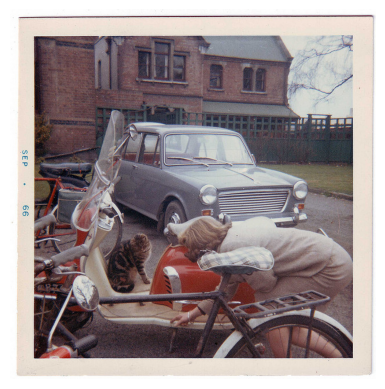

In [15]:
# Load and display one of the example images.
example_image = coco.loadImgs(image_IDs[1])[0]
print(example_image)

image = io.imread(f'{train_data_path}/data/{example_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

plt.show()

In [16]:
# Get COCO annotation IDs and content of annotations, i.e., bounding boxes and segmentation masks.

test_image_annotations_ID = coco.getAnnIds(
    imgIds=example_image["id"], catIds=category_IDs, iscrowd=None
)
print(test_image_annotations_ID)

test_image_annotations = coco.loadAnns(test_image_annotations_ID)
print(test_image_annotations)

[1878]
[{'id': 1878, 'image_id': 132, 'category_id': 18, 'bbox': [164.75, 387.63, 80.76, 103.53], 'segmentation': [[198.0, 490.5, 188.0, 489.5, 173.5, 482.0, 170.5, 466.0, 163.5, 453.0, 168.5, 437.0, 189.5, 400.0, 227.0, 386.5, 235.5, 390.0, 244.5, 411.0, 243.5, 424.0, 229.5, 442.0, 235.5, 460.0, 243.5, 471.0, 238.0, 478.5, 230.0, 476.5, 220.0, 449.5, 213.5, 465.0, 217.5, 481.0, 205.0, 489.5, 198.0, 490.5]], 'area': 8361.0828, 'iscrowd': 0, 'supercategory': 'animal'}]


In [17]:
# Load images for the specific id
image_ids = coco.getImgIds()
image_id = image_ids[1]  # Change this line to display a different image
image_info = coco.loadImgs(image_id)
print(image_info)

[{'id': 2, 'file_name': '000000000260.jpg', 'height': 333, 'width': 500, 'license': None, 'coco_url': None}]


{'id': 2, 'file_name': '000000000260.jpg', 'height': 333, 'width': 500, 'license': None, 'coco_url': None}


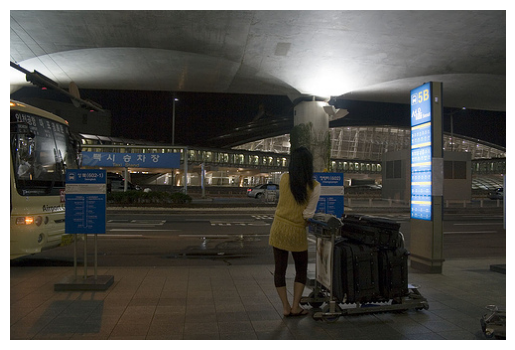

In [18]:
# Load and display one of the example images.
example_image = coco.loadImgs(image_id)[0]
print(example_image)

image = io.imread(f'{train_data_path}/data/{example_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

plt.show()

In [19]:
# Load annotations for the given ids
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
print(annotations)

[{'id': 24, 'image_id': 2, 'category_id': 14, 'bbox': [2.26, 93.77, 66.14, 157.86], 'segmentation': [[7.0, 249.5, 3.5, 243.0, 2.0, 92.5, 55.0, 106.5, 67.5, 142.0, 67.5, 156.0, 53.5, 161.0, 51.5, 186.0, 54.5, 195.0, 55.5, 233.0, 7.0, 249.5]], 'area': 10440.860400000001, 'iscrowd': 0, 'supercategory': 'vehicle'}, {'id': 25, 'image_id': 2, 'category_id': 41, 'bbox': [261.0, 139.88, 51.75, 169.5], 'segmentation': [[280.0, 308.5, 275.5, 307.0, 266.5, 277.0, 265.5, 241.0, 260.5, 232.0, 272.5, 168.0, 282.5, 160.0, 289.0, 138.5, 303.5, 150.0, 304.5, 170.0, 311.5, 179.0, 307.5, 196.0, 297.5, 213.0, 303.5, 242.0, 300.5, 267.0, 294.5, 279.0, 291.5, 295.0, 294.0, 305.5, 286.5, 305.0, 288.5, 265.0, 283.0, 246.5, 276.5, 264.0, 284.5, 301.0, 280.0, 308.5]], 'area': 8771.625, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 26, 'image_id': 2, 'category_id': 41, 'bbox': [17.29, 142.16, 23.67, 27.850000000000005], 'segmentation': [[25.0, 169.5, 16.5, 164.0, 20.5, 156.0, 19.5, 148.0, 26.0, 141.5, 29.5, 1

In [20]:
# Extract the training images that contain any combination of the four target classes.

target_classes = ["cake", "cat", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)
training_images = []

# Iterate over each individual class in the list.
for class_name in target_classes:
    # Get all images containing target class.
    print(class_name)
    training_images_categories = coco.getCatIds(catNms=class_name)
    training_images_IDs = coco.getImgIds(catIds=training_images_categories)
    training_images += coco.loadImgs(training_images_IDs)

print(
    f"Number of images with target classes including repetitions: {len(training_images)}."
)

cake
cat
dog
person
Number of images with target classes including repetitions: 287.


In [21]:
# category ids for target class
filterClasses = ["cake", "cat", "dog", "person"]
catIds = coco.getCatIds(catNms=filterClasses)
print(catIds)

[15, 18, 25, 41]


In [22]:
# print information for the category id
catID = 15
print(coco.loadCats(ids=catID))

imgId = coco.getImgIds(catIds=[catID])[0]
print(imgId)

[{'id': 15, 'name': 'cake', 'supercategory': 'food'}]
240


In [23]:
# annotation ids for image 'cake'
ann_ids = coco.getAnnIds(imgIds=[imgId], iscrowd=None)
print(ann_ids)

[3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272]


Annotations for Image ID 240:
000000016254.jpg


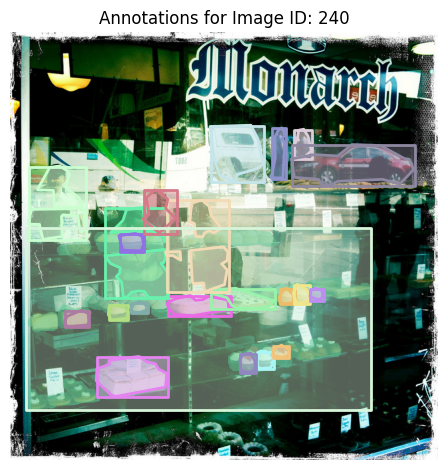

In [24]:
print(f"Annotations for Image ID {imgId}:")
anns = coco.loadAnns(ann_ids)

image_path = coco.loadImgs(imgId)[0]['file_name']
print(image_path)
image = plt.imread(train_data_path + '/data/' + image_path)
plt.imshow(image)

# Display the specified annotations
coco.showAnns(anns, draw_bbox=True)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(imgId))
plt.tight_layout()
plt.show()

Number of Unique Categories: 63
Category IDs:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
Categories Names:
['airplane', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'handbag', 'horse', 'hot dog', 'kite', 'knife', 'laptop', 'motorcycle', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'skateboard', 'skis', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'tennis racket', 'tie', 'traffic light', 'train', 'truck', 'umbrella', 'vase', 'wine glass']
Category

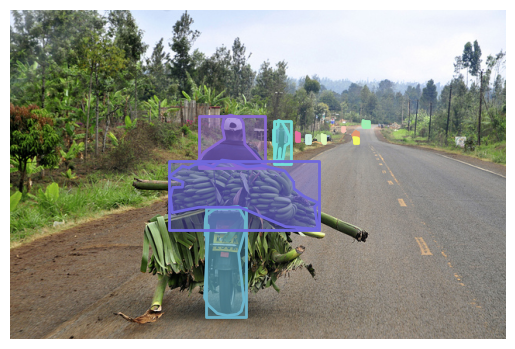

In [29]:
def main():
    # Category IDs
    cat_ids = coco.getCatIds()
    print(f"Number of Unique Categories: {len(cat_ids)}")
    print("Category IDs:")
    print(cat_ids)

    # All categories
    cats = coco.loadCats(cat_ids)
    cat_names = [cat["name"] for cat in cats]
    print("Categories Names:")
    print(cat_names)

    # Category ID -> Category Name.
    query_id = cat_ids[18]
    query_annotation = coco.loadCats([query_id])[0]
    query_name = query_annotation["name"]
    query_supercategory = query_annotation["supercategory"]
    print("Category ID -> Category Name:")
    print(
        f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}"
    )

    # Category Name -> Category ID
    query_name = cat_names[2]
    query_id = coco.getCatIds(catNms=[query_name])[0]
    print("Category Name -> ID:")
    print(f"Category Name: {query_name}, Category ID: {query_id}")

    # Get the ID of all the images containing the object of the category.
    img_ids = coco.getImgIds(catIds=[query_id])
    print(f"Number of Images Containing {query_name}: {len(img_ids)}")

    # Pick one image.
    img_id = img_ids[1]
    img_info = coco.loadImgs([img_id])[0]
    img_file_name = img_info["file_name"]
    img_url = img_info["coco_url"]
    print(
        f"Image ID: {img_id}, File Name: {img_file_name}, Image URL: {img_url}"
    )

    # Get all the annotations for the specified image.
    ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    print(f"Annotations for Image ID {img_id}:")
    print(anns)

    # Use URL to load image.
    # im = Image.open(requests.get(img_url, stream=True).raw)
    # Load image from dataset
    im = plt.imread(train_data_path + '/data/' + coco.loadImgs(img_id)[0]['file_name'])
    # Save image and its labeled version.
    plt.axis("off")
    plt.imshow(np.asarray(im))
    plt.savefig(f"{img_id}.jpg", bbox_inches="tight", pad_inches=0)
    # Plot segmentation and bounding box.
    coco.showAnns(anns, draw_bbox=True)
    plt.savefig(f"{img_id}_annotated.jpg", bbox_inches="tight", pad_inches=0)
    plt.show()
    return

if __name__ == "__main__":
    main()

<ipython-input-30-f26fb7cf6120>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts, y=category_names, palette=colors)


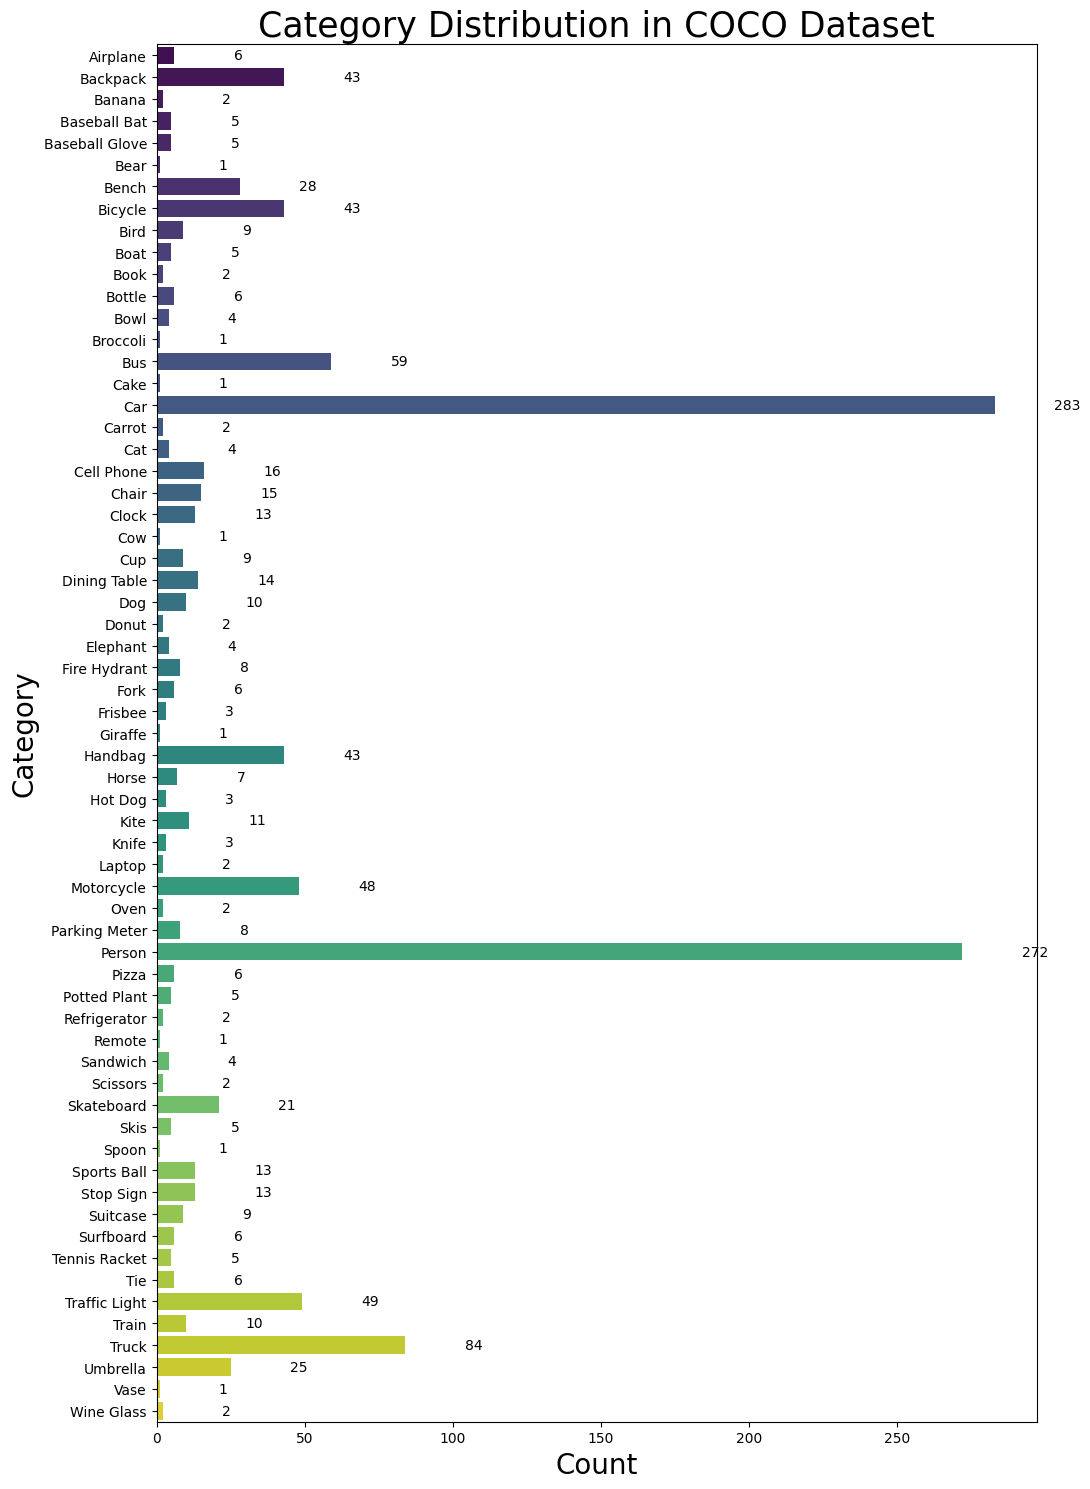

In [30]:
# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get category names
category_names = [cat['name'].title() for cat in cats]

# Get category counts
category_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
category_counts = [len(img_ids) for img_ids in category_counts]


# Create a color palette for the plot
colors = sns.color_palette('viridis', len(category_names))

# Create a horizontal bar plot to visualize the category counts
plt.figure(figsize=(11, 15))
sns.barplot(x=category_counts, y=category_names, palette=colors)

# Add value labels to the bars
for i, count in enumerate(category_counts):
    plt.text(count + 20, i, str(count), va='center')
plt.xlabel('Count',fontsize=20)
plt.ylabel('Category',fontsize=20)
plt.title('Category Distribution in COCO Dataset',fontsize=25)
plt.tight_layout()
plt.show()